In [2]:
import cv2
import numpy as np
import scipy.interpolate
import sys
import helpers
import open3d as o3d
import os
import plotly.graph_objects as go
from scipy.optimize import least_squares


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]


##Plot the images

['../teamB_sfm/test/web/images/0000.jpg', '../teamB_sfm/test/web/images/0001.jpg', '../teamB_sfm/test/web/images/0002.jpg', '../teamB_sfm/test/web/images/0003.jpg', '../teamB_sfm/test/web/images/0004.jpg', '../teamB_sfm/test/web/images/0005.jpg', '../teamB_sfm/test/web/images/0006.jpg', '../teamB_sfm/test/web/images/0007.jpg']


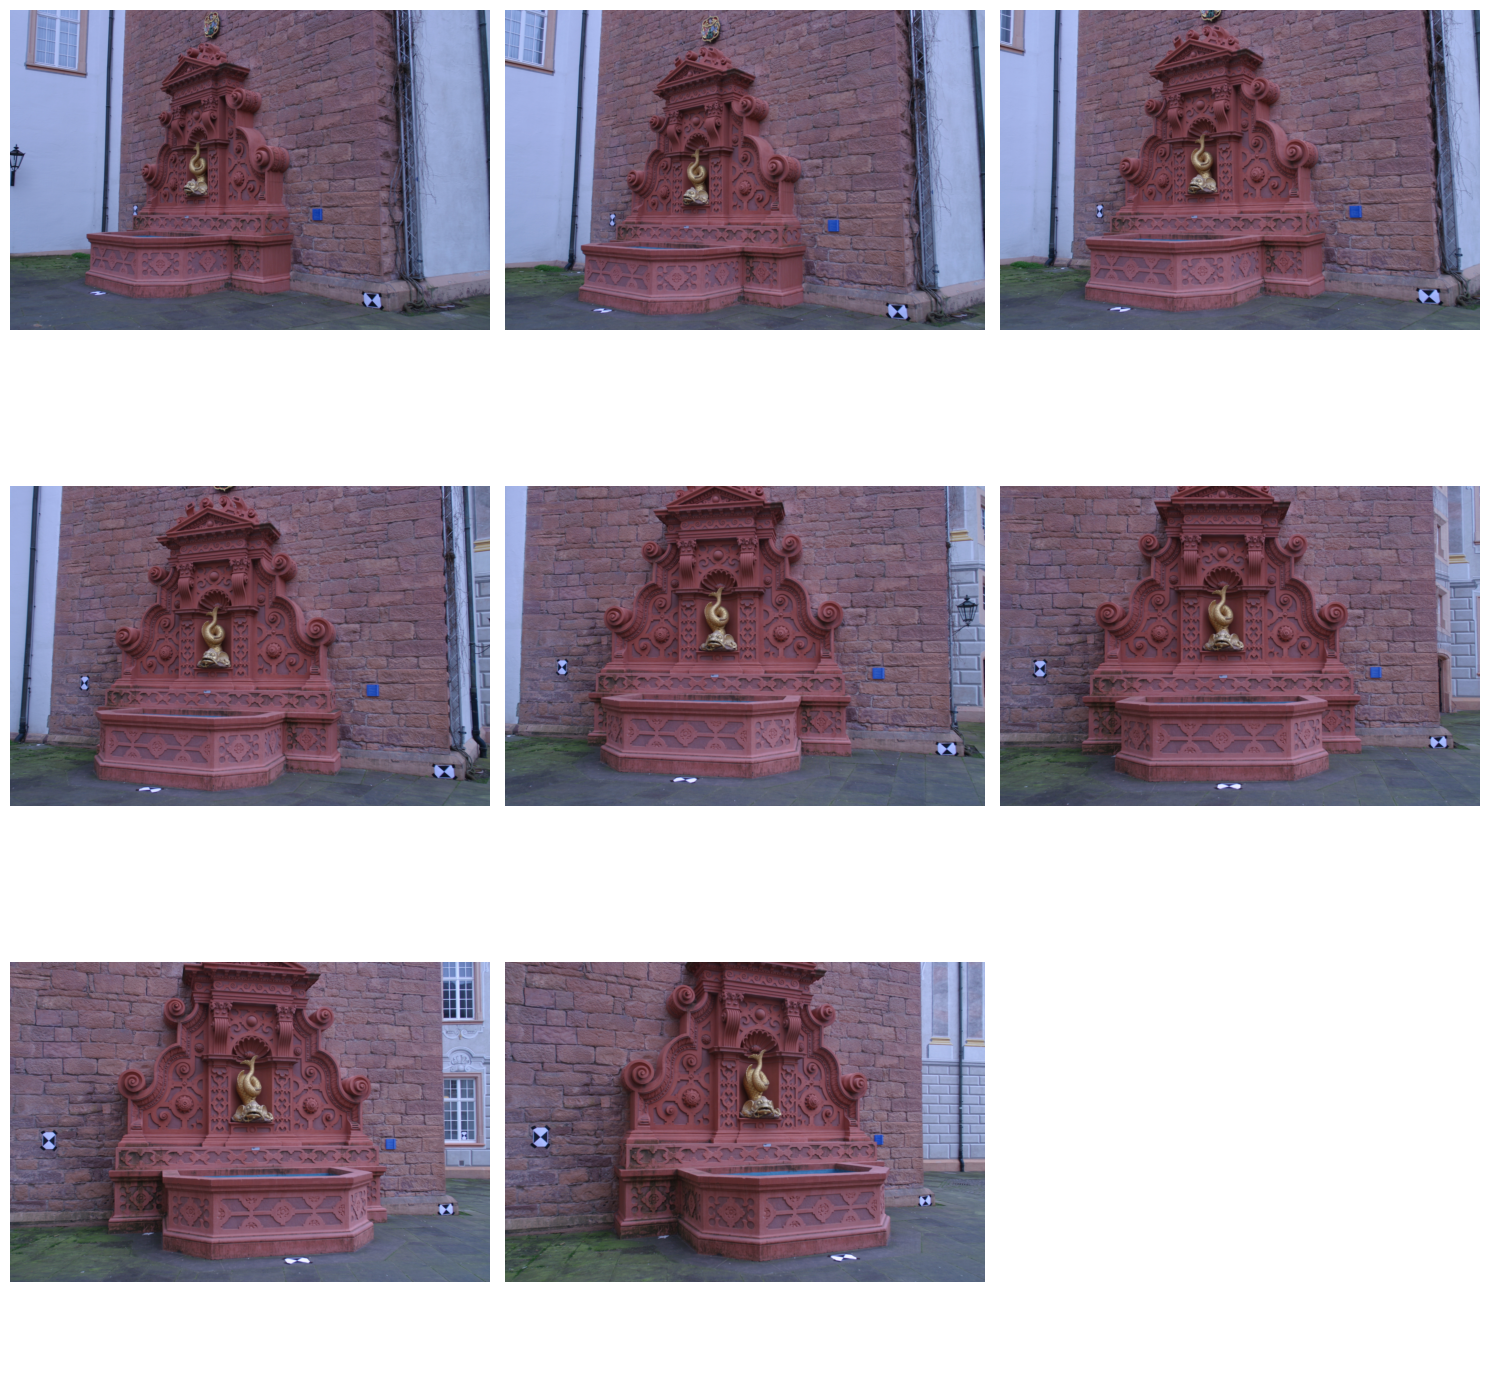

In [40]:
def plot_images(image_paths):

    n = len(image_paths)

    grid_size = int(n**0.5) + 1 if n**0.5 % 1 != 0 else int(n**0.5)

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

    axs = axs.flatten()

    for ax in axs[n:]:
        ax.axis('off')

    for img_path, ax in zip(image_paths, axs):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

import os
import glob

# test_path = "/Users/yeabsiramohammed/classes/es143/teamB_sfm/test/web/images"
test_path = "../teamB_sfm/test/web/images"

image_format = 'jpg'

search_pattern = os.path.join(test_path, f'*.{image_format}')
image_files = glob.glob(search_pattern)
image_files.sort()

image_paths = [path for path in image_files]
print(image_paths)
plot_images(image_paths)


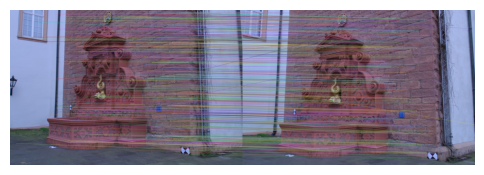

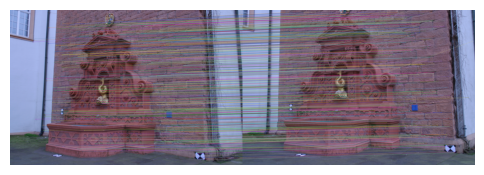

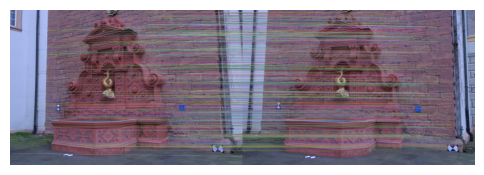

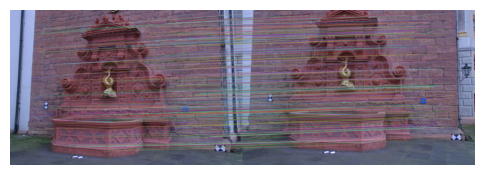

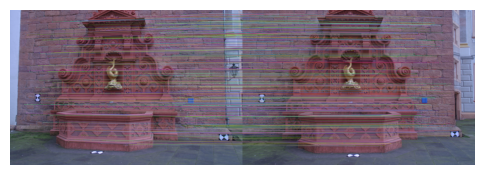

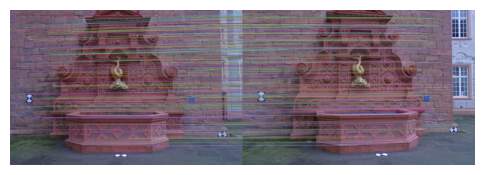

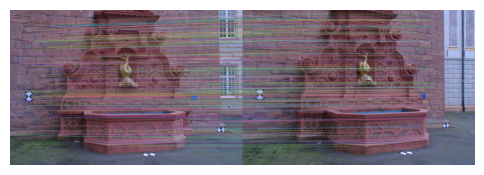

In [6]:

keypoints_list, descriptors_list = helpers.detect_features(image_paths)
matches_list_sequential = helpers.find_good_matches_sequential(descriptors_list)
matches_list_base = helpers.find_good_matches_base(descriptors_list, 0)
tracks = helpers.build_tracks(matches_list_sequential, keypoints_list)

# helpers.draw_base_matches(image_paths, matches_list_base, keypoints_list, 0)
# helpers.draw_global_matches(image_paths, tracks, keypoints_list)
helpers.draw_matches(image_paths, keypoints_list, matches_list_sequential)



In [37]:

class SceneReconstructor:
    def __init__(self, image_paths, K, results_path, base_image_index):
        self.image_paths = image_paths
        self.K = K
        self.results_path = results_path
        self.camera_poses = []
        self.keypoints_list, self.descriptors_list = helpers.detect_features(image_paths)
        self.base_image_index = base_image_index

        self.matches_list = helpers.find_good_matches(self.descriptors_list)

        self.points_3D = np.empty((0, 3), float)
        self.errors = []
        self.done = []
        self.point_map = {}
        self.point_counter = 0

  
    def compute_pose(self, view1, view2):
        self.view2 = view2
        keypoints1, keypoints2 = self.keypoints_list[view1], self.keypoints_list[view2]
        matches = self.matches_list[view1]
        points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        F, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC)
        mask = mask.ravel().astype(bool)
        points1 = points1[mask]
        points2 = points2[mask]
        filtered_matches = [matches[i] for i in range(len(mask)) if mask[i]]

        E = self.K.T @ F @ self.K
        _, R, t, _ = cv2.recoverPose(E, points1, points2, self.K)

        P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
        P2 = np.hstack((R, t))
        points_3D_hom = cv2.triangulatePoints(self.K @ P1, self.K @ P2, points1, points2)
        points_3D = (points_3D_hom[:3] / points_3D_hom[3]).T

        if self.points_3D.size == 0:
            # Get base scene
            self.points_3D = points_3D
            self.tracks = [[(view1, m.queryIdx, len(self.points_3D)-1)] for m in filtered_matches]

        else:
          # object_points = np.array([self.points_3D[self.point_map[(view1, m.queryIdx)]] for m in filtered_matches if (view1, m.queryIdx) in self.point_map])
          # image_points = points2[:len(object_points)]
          if len(points_3D) >= 4:  # solvePnPRansac needs at least 4 points
              success, rvec, tvec, inliers = cv2.solvePnPRansac(points_3D, points2[:len(points_3D)], self.K, None)
              if success:
                  R, _ = cv2.Rodrigues(rvec)
                  t = tvec
                  self.update_tracks_and_points(view1, view2, filtered_matches, inliers, points_3D)

        self.done.append((keypoints1, R, t))

        projected_points2 = cv2.projectPoints(points_3D, R, t, self.K, None)[0]
        error = np.mean(np.linalg.norm(projected_points2.squeeze() - points2.squeeze(), axis=1))
        self.errors.append(error)

    def update_tracks_and_points(self, view1, view2, matches, inliers, points_3D):
        """ Update the points and tracks based on inliers provided by solvePnPRansac """
        new_tracks = []
        for i in inliers.ravel():
            match = matches[i]
            point_idx = self.point_map.get((view2, match.trainIdx))
            # Ensure we only add tracks that are consistent with inliers
            new_tracks.append([(view1, match.queryIdx, point_idx), (view2, match.trainIdx, point_idx)])
        # self.tracks = new_tracks
        new_points = points_3D[inliers.ravel()]
        self.points_3D = np.vstack([self.points_3D, new_points])
        self.tracks.extend(new_tracks)



    def remove_top_percentage(self, percentage=10):
      """
      Removes the top 'percentage' of 3D points based on their distance from the centroid of all points.
      """
      if self.points_3D.size == 0:
          return

      centroid = np.mean(self.points_3D, axis=0)
      distances = np.linalg.norm(self.points_3D - centroid, axis=1)
      threshold = np.percentile(distances, 100 - percentage)
      valid_indices = np.where(distances < threshold)[0]
      new_points_3D = self.points_3D[valid_indices]

      index_map = {old_index: new_index for new_index, old_index in enumerate(valid_indices)}
      updated_tracks = []
      for track in self.tracks:
          updated_track = [(view_index, keypoint_index, index_map.get(point_index))
                          for view_index, keypoint_index, point_index in track
                          if point_index in index_map]
          if updated_track:
              updated_tracks.append(updated_track)

      self.points_3D = new_points_3D
      self.tracks = updated_tracks

    def bundle_adjust(self, ftol=1e-8):
      camera_parameter_count = 6 
      n_points = len(self.points_3D)
      initial_params = []
      for _, R, t in self.done:
          rvec, _ = cv2.Rodrigues(R)
          initial_params.extend(rvec.ravel())
          initial_params.extend(t.ravel())
      initial_params.extend(self.points_3D.ravel())

      def cost_function(params):
          n_cameras = len(self.done)
          camera_params = params[:n_cameras * camera_parameter_count].reshape((n_cameras, camera_parameter_count))
          points_3D = params[n_cameras * camera_parameter_count:].reshape((n_points, 3))
          projections = []

          for track in self.tracks:
              for view_index, keypoint_index, point_index in track:
                  view_index = view_index - 1
                  rvec = camera_params[view_index][:3]
                  tvec = camera_params[view_index][3:]
                  point_3D = points_3D[point_index]
                  keypoints = self.keypoints_list[view_index][keypoint_index].pt
                  projected, _ = cv2.projectPoints(np.array([point_3D]), rvec, tvec, self.K, None)
                  projections.extend(projected.ravel() - np.array(keypoints))

          return projections

      result = least_squares(cost_function, initial_params, verbose=2, x_scale='jac', ftol=ftol, method='trf')

      optimized_params = result.x
      camera_poses = []
      for i in range(len(self.done)):
          idx = i * camera_parameter_count
          rvec = optimized_params[idx:idx+3]
          tvec = optimized_params[idx+3:idx+6]
          R, _ = cv2.Rodrigues(rvec)
          pose_matrix = np.eye(4)
          pose_matrix[:3, :3] = R
          pose_matrix[:3, 3] = tvec
          camera_poses.append(pose_matrix)

      self.points_3D = optimized_params[len(camera_poses) * camera_parameter_count:].reshape((n_points, 3))
      return camera_poses

    def plot_points(self):

      pcd = o3d.geometry.PointCloud()
      pcd.points = o3d.utility.Vector3dVector(self.points_3D)
      o3d.io.write_point_cloud(os.path.join(self.results_path, f'reconstructed_balgo{self.view2}.ply'), pcd)
    def plot_points_to(self, filename):
      pcd = o3d.geometry.PointCloud()
      pcd.points = o3d.utility.Vector3dVector(self.points_3D)
      o3d.io.write_point_cloud(os.path.join(self.results_path, f'{filename}.ply'), pcd)

    def get_cam_positions(self):
      camera_positions = []
      R_global = np.eye(3)
      t_global = np.zeros((3,1))

      for _, R, t in self.done:
          t_global += R_global.dot(t)
          R_global = R.dot(R_global)
          camera_positions.append(t_global.copy())

      camera_positions = np.array(camera_positions).squeeze()

      return camera_positions
    
K = np.array([[2759.48, 0, 1520.69 ], [0, 2764.16, 1006.81], [0, 0, 1]])
results_path = '../teamB_sfm/results'

base_image_index = 0
image_count = 7
reconstructor = SceneReconstructor(image_paths, K, results_path, base_image_index)
for i in range(1,5):
    reconstructor.compute_pose(base_image_index, i)
    reconstructor.plot_points()

In [38]:
def plot_single_ply(ply_file_path):


    pcd = o3d.io.read_point_cloud(ply_file_path)
    if pcd.is_empty():
        print(f"Warning: '{ply_file_path}' is empty and will not be plotted.")
        return

    points_3D = np.asarray(pcd.points)
    xs = points_3D[:, 0]
    ys = points_3D[:, 1]
    zs = points_3D[:, 2]
    trace = go.Scatter3d(
        x=xs, y=ys, z=zs,
        mode='markers',
        marker=dict(
            size=2,
            opacity=0.8
        )
    )


    layout = go.Layout(
        title=f"3D Point Cloud from {ply_file_path}",

        margin=dict(l=0, r=0, b=0, t=0),
        paper_bgcolor='black',  # set the background color for each plot
        scene=dict(
            xaxis=dict(title='X', range = [-50,50]),
            yaxis=dict(title='Y', range = [-50,50] ),
            zaxis=dict(title='Z', range = [-50,50] ),
            aspectmode = 'cube',
            xaxis_showbackground=True,
            yaxis_showbackground=True,
            zaxis_showbackground=True
        )
    )

    fig = go.Figure(data=[trace], layout=layout)
    fig.show()

results_path = '../teamB_sfm/results/reconstructed_balgo2.ply'

plot_single_ply(results_path)

##Bundle Adjustment

In [17]:
camera_params = reconstructor.bundle_adjust(ftol=1e-4)
reconstructor.plot_points_to("bundle_adjusted")


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0003e+10                                    4.24e+10    
       1              2         6.4291e+09      3.57e+09       1.63e+01       2.33e+10    
       2              3         1.8951e+09      4.53e+09       9.34e+00       5.42e+09    
       3              4         4.3304e+08      1.46e+09       8.89e+00       9.21e+08    
       4              5         3.4930e+08      8.37e+07       4.80e+05       3.43e+08    
       5              7         3.3353e+08      1.58e+07       2.30e+05       1.18e+08    
       6              9         3.3235e+08      1.18e+06       5.66e+00       7.65e+07    
       7             11         3.3147e+08      8.78e+05       1.52e+00       3.88e+06    
       8             13         3.3146e+08      3.08e+03       6.95e-01       8.13e+05    
`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 1.0003e+1

In [39]:
results_path = '../teamB_sfm/results/bundle_adjusted.ply'
plot_single_ply(results_path)